# Importation des packages et connexion au S3

In [1]:
from helpers.other_helpers import *
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms


In [2]:
s3=s3_connection()

connection successful


# 1. La motivation

In [25]:
regional_stat=s3.get_tables_from_s3("clichere/diffusion/final_comm.parquet")
print(regional_stat[["pop2022", "revmoy2022", "psup2022", "pcadr2022"]].describe())

        pop2022  revmoy2022  psup2022  pcadr2022
count  36632.00    34720.00  35222.00   35065.00
mean    1829.92    17049.74      0.27       0.12
std     9954.65     5194.78      0.17       0.13
min        0.00     3350.48      0.00       0.00
25%      182.00    14011.97      0.16       0.00
50%      428.00    16321.86      0.26       0.08
75%     1116.00    19124.01      0.37       0.18
max   875791.00   126903.91      1.00       1.00


In [3]:
df=s3.get_tables_from_s3("aayrapetyan/diffusion/final_table.parquet")
print(df[["pop2022", "revmoy2022", "psup2022", "pcadr2022"]].describe())

             pop2022     revmoy2022     psup2022    pcadr2022
count    2808.000000    2808.000000  2808.000000  2808.000000
mean    18078.540954   18221.520429     0.293846     0.141033
std     50290.901554    6608.596156     0.132249     0.111082
min        55.000000    5818.043000     0.000000     0.000000
25%      1570.250000   14922.083000     0.203781     0.065058
50%      4067.500000   16931.457000     0.279855     0.121349
75%     12203.000000   19639.297250     0.365996     0.188963
max    875791.000000  107572.810000     1.000000     0.817073


On voit que la population moyenne diminue lorsque l'on sélectionne les communes ayant une gare. Cela correspond au fait que les petites communes ont moins de chance d'avoir une gare. On passe de 36000 communes à 2800 communes, ce qui donne tout de même beaucoup d'observations. On remarque que le revenu moyen d'une commune en France est plus élevé lorsque l'on sélectionne seulement les communes comprenant une gare. De même, les personnes sont en moyenne plus diplômée et appartiennent aux catégories socio-professionnelles plus élevées également. 

On veut montrer qu'il existe un lien entre le revenu, la catégorie socio-professionnelle (csp) et le fait de prendre un train en France. Pour cela, on effectue une régression linéaire avec le nombre total de voyageurs comme variable dépendante. Notre but est d'expliquer pourquoi est-ce que cette variable est différente en fonction des communes, en contrôlant par la population de la commune. Les premières visualisations et les premières données suggèrent qu'il peut y avoir un lien entre son revenu et le fait de prendre un train.

In [4]:
print(df.columns)

Index(['total_voyageurs_2022', 'nom_gare', 'uic', 'codeinsee', 'lon_gare',
       'lat_gare', 'codecommune', 'nomcommune', 'pop2022', 'revmoy2022',
       'pbac2022', 'psup2022', 'pagri2022', 'pindp2022', 'pcadr2022',
       'ppint2022', 'pempl2022', 'pouvr2022', 'pchom2022',
       'dist_closest_station_km', 'regions'],
      dtype='object')


# 2. Régressions

## 2.1. Transformer les variables pour notre modèle

In [4]:
dummies = pd.get_dummies(df['regions'], prefix=None)
dummies = dummies.astype(int)

df = pd.concat([df, dummies], axis=1)
df.sample(2)

,total_voyageurs_2022,nom_gare,uic,codeinsee,lon_gare,lat_gare,codecommune,nomcommune,pop2022,revmoy2022,...,Bretagne,Centre-Val de Loire,Grand Est,Hauts-de-France,Normandie,Nouvelle-Aquitaine,Occitanie,Pays de la Loire,Provence-Alpes-Côte d'Azur,Île-de-France
714,7022,Étigny - Véron,87683201,89160,3.290419,48.138683,89160,ETIGNY,768.0,18712.057,...,0,0,0,0,0,0,0,0,0,0
2432,1231,Hellemmes,87286062,59350,3.114933,50.622640,59350,LILLE,238369.0,15658.886,...,0,0,0,1,0,0,0,0,0,0


In [5]:
print(df.columns)

Index(['total_voyageurs_2022', 'nom_gare', 'uic', 'codeinsee', 'lon_gare',
       'lat_gare', 'codecommune', 'nomcommune', 'pop2022', 'revmoy2022',
       'pbac2022', 'psup2022', 'pagri2022', 'pindp2022', 'pcadr2022',
       'ppint2022', 'pempl2022', 'pouvr2022', 'pchom2022',
       'dist_closest_station_km', 'regions', 'Auvergne-Rhône-Alpes',
       'Bourgogne-Franche-Comté', 'Bretagne', 'Centre-Val de Loire',
       'Grand Est', 'Hauts-de-France', 'Normandie', 'Nouvelle-Aquitaine',
       'Occitanie', 'Pays de la Loire', 'Provence-Alpes-Côte d'Azur',
       'Île-de-France'],
      dtype='object')


In [6]:
df['pnodip2022']=1-df['pbac2022']
df[['pbac2022', 'psup2022', 'pnodip2022', 'pagri2022', 'pempl2022', 'pcadr2022', 'pchom2022', 'pindp2022', 'pouvr2022', 'ppint2022']]=df[['pbac2022', 'psup2022', 'pnodip2022', 'pagri2022', 'pempl2022', 'pcadr2022', 'pchom2022', 'pindp2022', 'pouvr2022', 'ppint2022']]*100

## 2.2 Régressions simples

On enlève des csp les professions indépendantes qui regroupe des personnes très hétérogènes pour éviter la colinéarité parfaite. On enlève la Corse pour la même raison.

In [7]:

X = df[['revmoy2022', 'pop2022', 'pnodip2022', 'psup2022', 'pcadr2022', 'pouvr2022', 'pchom2022', 'pempl2022','ppint2022', 'pagri2022', 'dist_closest_station_km', 'Auvergne-Rhône-Alpes', 'Bourgogne-Franche-Comté', 'Bretagne', 'Centre-Val de Loire', 'Grand Est', 'Hauts-de-France', 'Normandie', 'Nouvelle-Aquitaine', 'Occitanie', 'Pays de la Loire', 'Provence-Alpes-Côte d\'Azur', 'Île-de-France']]
Y = df['total_voyageurs_2022']  



model0 = sm.OLS(Y, sm.add_constant(X)).fit()

print(model0.summary())

                             OLS Regression Results                             
Dep. Variable:     total_voyageurs_2022   R-squared:                       0.215
Model:                              OLS   Adj. R-squared:                  0.209
Method:                   Least Squares   F-statistic:                     34.65
Date:                  Sat, 28 Dec 2024   Prob (F-statistic):          7.90e-129
Time:                          02:54:52   Log-Likelihood:                -45685.
No. Observations:                  2808   AIC:                         9.142e+04
Df Residuals:                      2785   BIC:                         9.155e+04
Df Model:                            22                                         
Covariance Type:              nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------


In [8]:
summary0_df = model0.summary2().tables[1]
print(summary0_df)

                                   Coef.      Std.Err.          t  \
const                      -2.676070e+06  1.089218e+06  -2.456873   
revmoy2022                  7.911336e+01  1.070816e+01   7.388141   
pop2022                     1.170606e+01  1.185008e+00   9.878463   
pnodip2022                  1.200759e+04  9.689358e+03   1.239255   
psup2022                    2.046930e+04  1.090082e+04   1.877776   
pcadr2022                   1.030505e+04  1.142734e+04   0.901789   
pouvr2022                   1.322956e+04  9.858550e+03   1.341937   
pchom2022                   2.219652e+04  1.161783e+04   1.910557   
pempl2022                   7.165892e+03  1.006170e+04   0.712195   
ppint2022                  -9.968304e+03  1.012976e+04  -0.984062   
pagri2022                   9.294775e+03  1.587322e+04   0.585563   
dist_closest_station_km     5.683471e+03  1.605963e+04   0.353898   
Auvergne-Rhône-Alpes       -4.879199e+05  1.769692e+05  -2.757089   
Bourgogne-Franche-Comté    -4.5309

On obtient des coefficients significatifs sauf pour le taux de personnes sans diplôme dans la commune.

Essayons de passer au logarithme du nombre de voyageurs pour capturer des non-linéarités potentielles.

In [9]:
df['log_nb_voy2022']= np.log(df['total_voyageurs_2022'])
df = delete_outliers_z_score(df, (df["log_nb_voy2022"]))

nb removed observations :  18


In [10]:
X = df[['revmoy2022', 'pop2022', 'psup2022', 'pnodip2022', 'pcadr2022', 'pouvr2022', 'pchom2022', 'pempl2022', 'pagri2022', 'ppint2022', 'dist_closest_station_km', 'Auvergne-Rhône-Alpes', 'Bourgogne-Franche-Comté', 'Bretagne', 'Centre-Val de Loire', 'Grand Est', 'Hauts-de-France', 'Normandie', 'Nouvelle-Aquitaine', 'Occitanie', 'Pays de la Loire', 'Provence-Alpes-Côte d\'Azur', 'Île-de-France']]
Y = df['log_nb_voy2022']  


model1 = sm.OLS(Y, sm.add_constant(X)).fit()

print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:         log_nb_voy2022   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     76.31
Date:                Sat, 28 Dec 2024   Prob (F-statistic):          5.44e-265
Time:                        02:55:01   Log-Likelihood:                -5742.6
No. Observations:                2790   AIC:                         1.153e+04
Df Residuals:                    2767   BIC:                         1.167e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [11]:
summary1_df = model1.summary2().tables[1]
print(summary1_df)

                               Coef.      Std.Err.          t          P>|t|  \
const                       6.702652  7.369024e-01   9.095712   1.748567e-19   
revmoy2022                 -0.000009  7.220003e-06  -1.205641   2.280589e-01   
pop2022                     0.000007  7.980318e-07   9.347428   1.792319e-20   
psup2022                    0.022550  7.404080e-03   3.045603   2.344034e-03   
pnodip2022                  0.013663  6.572665e-03   2.078754   3.773193e-02   
pcadr2022                   0.036514  7.741195e-03   4.716895   2.513532e-06   
pouvr2022                   0.015380  6.684050e-03   2.300982   2.146663e-02   
pchom2022                   0.049359  7.904476e-03   6.244441   4.907121e-10   
pempl2022                   0.015400  6.834259e-03   2.253401   2.431186e-02   
pagri2022                  -0.069329  1.070873e-02  -6.474094   1.124465e-10   
ppint2022                   0.010781  6.863011e-03   1.570938   1.163114e-01   
dist_closest_station_km     0.085401  1.

On note que les coefficients sont significatifs sauf pour le revenu moyen des communes. Après avoir contrôlé pour les autres variables, et en ajustant le nombre de voyageur en logarithme, les effets du revenu ainsi que le fait de n'avoir pas de diplôme ne sont plus significatifs. En revanche, tous les autres coefficients le sont à 1% sauf la distance de la gare la plus proche, dont le coefficient est significatif à 5%. Notons que le R^2 ajusté se situe autour de 35% ce qui est élevé.

## 2.3. Ajuster notre modèle

### 2.3.1. Distance de Cook

Distances de Cook: [2.81440871e-06 3.82485216e-04 2.50363373e-05 ... 5.81007862e-07
 1.38474575e-06 1.83299898e-03]
Indices des points influents: [False False False ... False False  True]
153


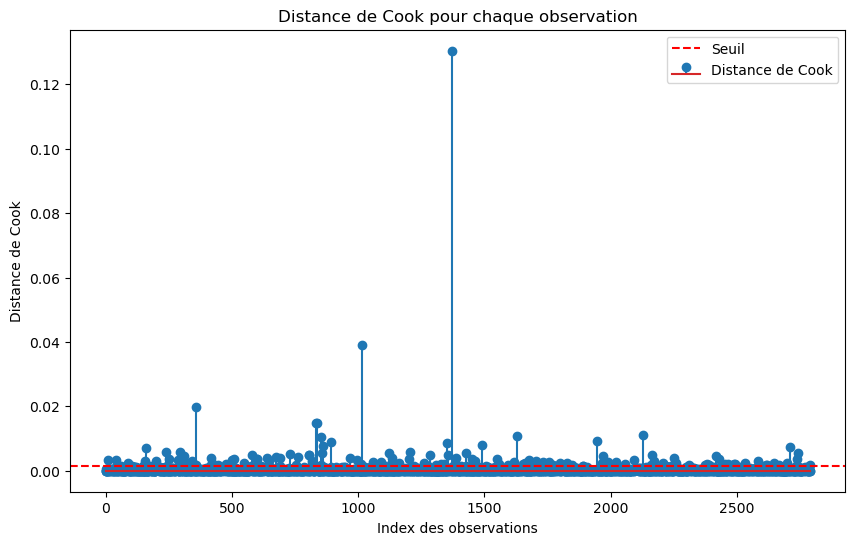

In [12]:
influence = model1.get_influence()

cooks_d, _ = influence.cooks_distance
print("Distances de Cook:", cooks_d)

threshold = 4 / len(X)
influential_points = cooks_d > threshold

print("Indices des points influents:", influential_points)

num_influential_points = sum(influential_points)
print(num_influential_points)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.stem(range(len(cooks_d)), cooks_d, markerfmt='o', label="Distance de Cook")
plt.axhline(y=threshold, color='r', linestyle='--', label="Seuil")
plt.xlabel("Index des observations")
plt.ylabel("Distance de Cook")
plt.title("Distance de Cook pour chaque observation")
plt.legend()
plt.show()

On voit que il y a peu de outliers, donc on peut continuer sans les éliminer, les outliers sont déjà éliminés grace à Z-score

Nous allons effectuer un test de Breusch-Pagan pour détecter l’hétéroscédasticité potentielle.

In [13]:
test_breusch_pagan = sms.het_breuschpagan(model1.resid, model1.model.exog)

lm_stat, lm_p_value, f_stat, f_p_value = test_breusch_pagan

print("Statistique de Breusch-Pagan:", lm_stat)
print("P-valeur de Breusch-Pagan:", lm_p_value)
print("Statistique F:", f_stat)
print("P-valeur F:", f_p_value)

Statistique de Breusch-Pagan: 304.1164202711656
P-valeur de Breusch-Pagan: 6.735763985691799e-51
Statistique F: 15.386702699124701
P-valeur F: 8.35829510139758e-55


La p-value est très proche de 0 donc on peut rejeter l'hypothèse d’homoscédasticité. Essayons d'ajuster notre modèle à l'aide des erreurs standards robustes de type HC3.

In [14]:
model1_robust = sm.OLS(Y, sm.add_constant(X)).fit(cov_type='HC3')

# Affichage des résultats avec erreurs robustes
print(model1_robust.summary())

                            OLS Regression Results                            
Dep. Variable:         log_nb_voy2022   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     4947.
Date:                Sat, 28 Dec 2024   Prob (F-statistic):               0.00
Time:                        02:55:30   Log-Likelihood:                -5742.6
No. Observations:                2790   AIC:                         1.153e+04
Df Residuals:                    2767   BIC:                         1.167e+04
Df Model:                          22                                         
Covariance Type:                  HC3                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [15]:
column_names = X.columns  
#perform stepwise selection algorithm to select best covariates based on AIC/BIC measure
selected_columns = column_names[np.sort((stepwise_selection(X,Y,aic="aic")))]
#run final model on these selected variables
model1_robust = sm.OLS(Y, sm.add_constant(X[selected_columns])).fit(cov_type='HC3')
# Affichage des résultats avec erreurs robustes
print(model1_robust.summary())

                            OLS Regression Results                            
Dep. Variable:         log_nb_voy2022   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     140.3
Date:                Sat, 28 Dec 2024   Prob (F-statistic):               0.00
Time:                        02:56:02   Log-Likelihood:                -5746.9
No. Observations:                2790   AIC:                         1.153e+04
Df Residuals:                    2774   BIC:                         1.162e+04
Df Model:                          15                                         
Covariance Type:                  HC3                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [16]:
summary_corr_het_df = model1_robust.summary2().tables[1]
print(summary_corr_het_df)

                               Coef.  Std.Err.          z          P>|z|  \
const                       6.857547  0.808271   8.484217   2.171768e-17   
revmoy2022                 -0.000012  0.000008  -1.371550   1.702035e-01   
pop2022                     0.000008  0.000002   3.859846   1.134584e-04   
psup2022                    0.020321  0.009264   2.193510   2.827069e-02   
pnodip2022                  0.010116  0.007818   1.293864   1.957124e-01   
pcadr2022                   0.039222  0.009161   4.281312   1.857948e-05   
pouvr2022                   0.020033  0.007675   2.610332   9.045450e-03   
pchom2022                   0.045554  0.011180   4.074565   4.610042e-05   
pempl2022                   0.013815  0.007778   1.776201   7.569979e-02   
pagri2022                  -0.067663  0.011856  -5.706944   1.150228e-08   
ppint2022                   0.012115  0.007470   1.621843   1.048369e-01   
dist_closest_station_km     0.083404  0.012234   6.817654   9.253942e-12   
Auvergne-Rhô

Augmenter d'un point de pourcentage la proportion de cadre dans la commune augmente de 0.02% le nombre de voyageur dans une gare. Le coefficient ne peut pas être interprété comme un effect causal dû à l'endogénéité du modèle. La densité de population peut être perçue comme un biais de variable oubliée.  

# 3. Conclusion

Nous avons montrer qu'il existe un lien entre le pourcentage de catégories socio-professionnels et le nombre de voyageurs dans les communes. Cela ne suffit pas à en déduire un lien causal dû à l'endogénéité du modèle. Cela ne nous donne pas un modèle causal mais un modèle de prédiction. Il faudrait ajouter certaines variables comme les variables de densité de population ou de types de transports utilisés. 